<img src = "./img/logo.png" 
     height = "170"
     width = "150"
     align = "right" />

# Progetto

Denise Cilia <br>
X81000791 <br>
Social Media Management <br>
A.A 21/22
***

# Introduzione

In uno studio di profilazione condotto sulla piattaforma di <a href="https://store.steampowered.com/">Steam</a> su un profilo utente in particolare, è stato costruito un dataset contenente 297 record inerenti ai giochi posseduti dall'utente. Troviamo al suo interno informazioni come: 
* l'<b>id</b> univoco del gioco; 
* il <b>nome</b> del gioco; 
* le <b>ore di gioco</b>; 
* se è stato giocato nelle ultime <b>due settimane</b>; 
* ed infine il <b>genere</b> del gioco.

Su questo dataset verrà applicata una fase di filtering in maniera tale da concentrarci solamente sui giochi effettivamente giocati dall'utente evitando così un'elaborazione troppo ampia. <br>
In un secondo momento verranno aggiunte al dataset in studio le colonne <b>review</b> e <b>label</b>, contenenti rispettivamente tutte le recensioni ottenute attraverso scraping della pagina web del gioco in particolare, e le varie etichette ad indicare se si tratta di una recensione positiva o negativa. <br>
<br>
Lo scopo di questo progetto è costruire un piccolo sistema di raccomandazione per l'utente. Questo lavoro verrà svolto ottenendo le recensioni per un determinato gioco, ad esempio il gioco più giocato dall'utente, e procedendo con una rappresentazione delle recensioni attraverso il modello <b>Bag of Words</b>. Successivamente si ricerca sullo Steam Store un gioco dello stesso genere del gioco selezionato, e allo stesso modo si ricavano dalla pagina web tutte le recensioni disponibili che vengono rappresentate mediante lo stesso modello sopracitato. Il risultato di entrambe le elaborazioni sarà contenuto in due vettori separati sulla quale verrà applicato il calcolo della <b>similarità del Coseno</b>, che darà in output un risultato mediante il quale sarà possibile consigliare o meno all'utente il gioco in questione. 
***

Inizialmente importiamo il dataset ed effettuiamo delle semplici operazioni di filtering.

In [2]:
import pandas as pd

data = pd.read_csv('./games.csv')
data

,id,name,hours_of_game,recently_played,genres
0,20,Team Fortress Classic,0,no,Action
1,15710,Oddworld: Abe's Exoddus,0,no,Adventure
2,9480,Saints Row 2,0,no,Action
3,1250,Killing Floor,1,no,Action
4,35420,Killing Floor Mod: Defence Alliance 2,0,no,Action
...,...,...,...,...,...
291,46510,Syberia 2,0,no,Adventure
292,204450,Call of Juarez Gunslinger,0,no,Action
293,520720,Dear Esther: Landmark Edition,0,no,Adventure Casual Indie
294,1577120,The Quarry,0,no,Adventure


In [3]:
new_data = data[data['hours_of_game'] >= 20] # filter

new_data.index = range(len(new_data)) # re-impostiamo gli indici delle righe
new_data

,id,name,hours_of_game,recently_played,genres
0,105600,Terraria,623,no,Action Adventure Indie RPG
1,113200,The Binding of Isaac,99,yes,Action Adventure Indie RPG
2,205100,Dishonored,21,no,Action Adventure
3,221040,Resident Evil 6,62,no,Action Adventure
4,222480,Resident Evil Revelations,109,no,Action Adventure
5,211820,Starbound,79,no,Action Adventure Casual Indie RPG
6,235460,METAL GEAR RISING: REVENGEANCE,20,no,Action
7,254700,Resident Evil 4,38,no,Action Adventure
8,335300,DARK SOULS™ II: Scholar of the First Sin,74,no,Action RPG
9,250900,The Binding of Isaac: Rebirth,392,yes,Action


Passiamo adesso all'operazione di <a href="https://it.wikipedia.org/wiki/Web_scraping">web scraping</a> che ci permetterà di ottenere le informazioni ricercate, ovvero recensione e tipo di recensione: se positiva o negativa. 

In [4]:
import requests

def get_reviews(appid, params = {'json':1}):
        url = 'https://store.steampowered.com/appreviews/' + appid
        response = requests.get(url = url, params = params, headers = {'User-Agent': 'Mozilla/5.0'})
        
        return response.json()

In [5]:
def get_n_reviews(appid, n = 100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100
        
        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

    return reviews

La funzione <code class="bb_code bb_code_inline nohighlight">get_n_reviews</code>(¹) dà in output <i>n</i> recensioni su un determinato gioco descritto dal suo <b>id</b> univoco. <br>
Adesso definiamo una serie di funzioni utili alla pulizia del testo. In particolare rimuoveremo dal testo di ciascuna delle recensioni: i tag del tipo <b>[tag]</b>, le emoji, le end line <b>\n</b> e i numeri.

In [6]:
import re

def removeSquareBracketsTag(data):
    pattern = r'\[.*?\]'
    return re.sub(pattern, '', data)

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def removeEndLines(data):
    return re.sub(r'\n', '', data)

def remove_number(data):
    data = data.lower()
    data = re.sub(r'\d+', '', data)
    return data

In [7]:
def addToDataset(data_param):
    reviews = []    
    dictListForReview = []
    dictListForLabels = []

    appids = data_param['id'].to_numpy()
    for i in range(len(appids)):
        reviews = get_n_reviews(str(appids[i]), 100)
        df = pd.DataFrame(reviews)[['review', 'voted_up']]
    
        for j in range(len(df['review'])):
            df.at[j, 'review'] = remove_emojis(df.iloc[j]['review'])
            df.at[j, 'review'] = removeSquareBracketsTag(df.iloc[j]['review'])
            df.at[j, 'review'] = removeEndLines(df.iloc[j]['review'])
            df.at[j, 'review'] = remove_number(df.iloc[j]['review'])
        
        label_dict = df['voted_up'].to_dict()
        review_dict = df['review'].to_dict()
        dictListForReview.append(review_dict)
        dictListForLabels.append(label_dict)
    copy = data_param
    copy['review'] = dictListForReview
    copy['label'] = dictListForLabels
    
    return copy

Definendo la funzione <code class="bb_code bb_code_inline nohighlight">addToDataset</code> prendiamo tutti gli id nel dataset ed estraiamo per ciascun record presente tutte le recensioni e le etichette del gioco in questione, aggiungendo queste nuove informazioni all'interno di due nuove colonne <b>review</b> e <b>label</b> che si troveranno in un nuovo dataframe di copia.<br>
Più formalmente prendendo in considerazione la riga <i>i</i>-esima del nuovo dataset, avremo in output nella colonna review una lista di recensioni e una lista di etichette nella colonna label con una corrispondenza 1-a-1. Nella <i>j</i>-esima posizione faremo riferimento alla <i>j</i>-esima etichetta

In [8]:
new_data_2 = addToDataset(new_data)

In [9]:
new_data_2

,id,name,hours_of_game,recently_played,genres,review,label
0,105600,Terraria,623,no,Action Adventure Indie RPG,"{0: 'terraria’s final major update, journey’s ...","{0: True, 1: True, 2: True, 3: True, 4: True, ..."
1,113200,The Binding of Isaac,99,yes,Action Adventure Indie RPG,{0: 'this is definitely one of the greatrest g...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
2,205100,Dishonored,21,no,Action Adventure,{0: '/pros you really fall in love with th...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
3,221040,Resident Evil 6,62,no,Action Adventure,{0: 'leon. this is chris. i have an urgent mis...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
4,222480,Resident Evil Revelations,109,no,Action Adventure,{0: 'resident evil revelations is capcom's att...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
5,211820,Starbound,79,no,Action Adventure Casual Indie RPG,{0: 'this review is for version . starbound is...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
6,235460,METAL GEAR RISING: REVENGEANCE,20,no,Action,"{0: 'senator armstrong is so cool, i wish amer...","{0: True, 1: True, 2: True, 3: True, 4: True, ..."
7,254700,Resident Evil 4,38,no,Action Adventure,{0: 'don't worry you are not only one who play...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
8,335300,DARK SOULS™ II: Scholar of the First Sin,74,no,Action RPG,{0: 'tl;drbuy it if you prefer the individual ...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
9,250900,The Binding of Isaac: Rebirth,392,yes,Action,{0: 'rebirth is an amazing game! it improved o...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."


Concentriamo il nostro studio sui giochi più recentemente giocati dall'utente nelle ultime due settimane e con le più alte ore di gioco, così da ottenere: 

In [10]:
mostPlayed = new_data_2[(new_data_2['hours_of_game'] >= 600) & (new_data_2['recently_played'] == "yes")]
mostPlayed

,id,name,hours_of_game,recently_played,genres,review,label
13,322330,Don't Starve Together,942,yes,Adventure Indie Simulation,{0: 'awesome game.my ex gave me this game. we ...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
30,1201240,BLEACH Brave Souls - 3D Action,636,yes,Action Casual Free to Play RPG,"{0: 'bankai deez nuts', 1: 'as a disclaimer, t...","{0: True, 1: True, 2: True, 3: True, 4: True, ..."


In [11]:
firstGameReview = mostPlayed.iloc[0]['review']

In [12]:
docs = []
for i in range(len(firstGameReview)):
    docs.append((firstGameReview[i]))

Estraiamo le recensioni del primo gioco e utilizziamo un ciclo <i>for</i> per inserire ciascuna recensione come singolo elemento in un array di stringhe. Quindi trasformiamo il dizionario in un array. Questa operazione ci servirà per poter usufruire del metodo <code class="bb_code bb_code_inline nohighlight">CountVectorizer</code>.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
cv_fit = cv.fit_transform(docs)
wordList = cv.get_feature_names() 
countList = cv_fit.toarray().sum(axis=0)
result = dict(zip(wordList, countList))

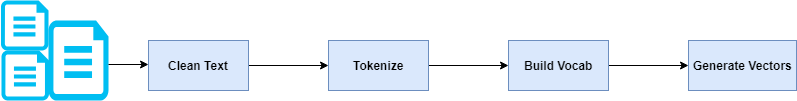

Il metodo <code class="bb_code bb_code_inline nohighlight">CountVectorizer</code> viene utilizzato per convertire una collezione di documenti di testo in un vettore conteggio di termini o token. È possibile effettuare un ulteriore pre-processing sui dati, il quale permette di eliminare la punteggiatura e altre cosiddette <b>stop words</b>: parole non significative per il processo di <b>NLP</b> (Natural Language Processing). Visualizziamo il risultato:

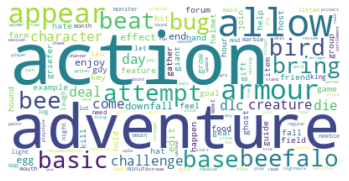

In [14]:
unique_string = (" ").join(wordList)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(unique_string)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Adesso utilizziamo un'ulteriore tecnica di web scraping(²) per poter usufruire della funziore <b>ricerca</b> nello Store ufficiale di Steam. Tramite questo riusciremo ad individuare un numero <i>n</i> di giochi con il loro id univoco e specificandone il genere.

In [15]:
from bs4 import BeautifulSoup

headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.134 Safari/537.36'}
def searchStore(n, term):
    game = []
    id = []
    while len(game) < n:
        url = f'https://store.steampowered.com/search/?term={term}&category1=998'
        html = requests.get(url, headers=headers).text
        soup = BeautifulSoup(html, 'html.parser')
        search_results = soup.find_all(class_='search_result_row')
        
        if not search_results:
            break
        
        title = [result.find('span', class_='title').text for result in search_results]
        appid = [result['data-ds-appid'] for result in search_results]
        game.extend(title)
        id.extend(appid)
    num = min(n, len(game))
    return pd.DataFrame({
        'game':game[:num],
        'id':id[:num]
    })

In [16]:
suggested = searchStore(15, term = 'Adventure+Indie+Simulation')
suggested

,game,id
0,The Mortuary Assistant,1295920
1,BONELAB,1592190
2,Escape Simulator,1435790
3,Noita,881100
4,Thief Simulator,704850
5,BONEWORKS,823500
6,MADiSON,1670870
7,House Party,611790
8,This War of Mine,282070
9,Stranded Deep,313120


Estraiamo in maniera randomica solo due campioni dal dataframe <b>suggested</b> per rendere l'elaborazione più snella e veloce.

In [17]:
random_suggest = suggested.sample(n = 2)
random_suggest

,game,id
5,BONEWORKS,823500
4,Thief Simulator,704850


In [18]:
new_suggested = addToDataset(random_suggest)

Andremo ad aggiungere anche qui recensioni ed etichette.

In [19]:
new_suggested

,game,id,review,label
5,BONEWORKS,823500,{0: ' - there was a turret down the street kee...,"{0: True, 1: True, 2: True, 3: True, 4: True, ..."
4,Thief Simulator,704850,"{0: 'i stole this game', 1: 'this game is awes...","{0: True, 1: True, 2: True, 3: True, 4: True, ..."


In [20]:
firstGameReview = new_suggested.iloc[0]['review']

docs2 = []
for i in range(len(firstGameReview)):
    docs2.append((firstGameReview[i]))
    
cv2 = CountVectorizer(stop_words = 'english')
cv2_fit = cv2.fit_transform(docs2)
wordList2 = cv2.get_feature_names() 
countList2 = cv2_fit.toarray().sum(axis=0)
result2 = dict(zip(wordList2, countList2))

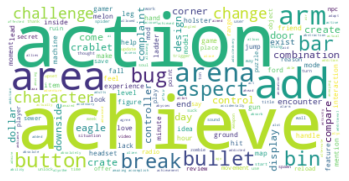

In [21]:
unique_string2 = (" ").join(wordList2)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(unique_string2)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Calcoliamo infinite la <b>similarità del Coseno</b>. La similarità del coseno è una tecnica euristica per la misurazione della similitudine tra due vettori effettuata calcolando il coseno tra di loro, usata generalmente per il confronto di testi nell'estrazione di dati e nell'analisi testuale. <br>
Nel caso dell'analisi dei testi, poiché le frequenze dei termini sono sempre valori positivi, si otterranno valori che vanno da 0 a +1, dove +1 indica che le parole contenute nei due testi sono le stesse (ma non necessariamente nello stesso ordine) e 0 che non c'è nessuna parola che appare in entrambi.(³)

In [22]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from decimal import Decimal

def cosineSimilarity(par1, par2):

    # count word occurrences
    a_vals = Counter(par1)
    b_vals = Counter(par2)

    # convert to word-vectors
    words  = list(a_vals.keys() | b_vals.keys())
    a_vect = [a_vals.get(word, 0) for word in words]       
    b_vect = [b_vals.get(word, 0) for word in words]        

    # find cosine
    len_a  = sum(av*av for av in a_vect) ** 0.5             
    len_b  = sum(bv*bv for bv in b_vect) ** 0.5             
    dot    = sum(av*bv for av,bv in zip(a_vect, b_vect))   
    cosine = dot / (len_a * len_b)

    print(round(Decimal(cosine), 2))

In [23]:
cosineSimilarity(wordList, wordList2) # Don't Starve Together / BONEWORKS

0.37


In questo caso la somiglianza è del <b>37%</b>, il gioco potrebbe essere consigliato all'utente, ma l'utente potrebbe non gradirlo. Proviamo con il secondo gioco nella lista:

In [24]:
secondGameReview = new_suggested.iloc[1]['review']

docs3 = []
for i in range(len(secondGameReview)):
    docs3.append((secondGameReview[i]))
    
cv3 = CountVectorizer(stop_words = 'english')
cv3_fit = cv3.fit_transform(docs3)
wordList3 = cv3.get_feature_names()
countList3 = cv3_fit.toarray().sum(axis=0)
result3 = dict(zip(wordList3, countList3))

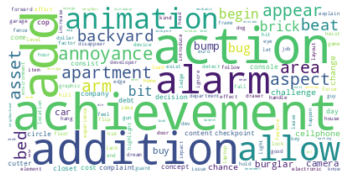

In [25]:
unique_string3 = (" ").join(wordList3)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(unique_string3)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
cosineSimilarity(wordList, wordList3) # Don't Starve Together / Thief Simulator

0.37


Anche qui otteniamo un grado di accuratezza del <b>37%</b>. Anche questo gioco potrebbe essere consigliato all'utente ma potrebbe non apprezzarlo.

# Conclusioni

Lo studio porta alla formulazione di un sistema di raccomandazione molto semplice che permette di suggerire dei titoli, ma difficilmente permette di ottenere risultati sopra il <b>50%</b> di accuratezza in quanto il sistema di recensione è fortemente legato al gioco che viene studiato. Ad esempio per il titolo <i>Don't Starve Together</i> appaiono frequentemente nei termini i nomi dei protagonisti del gioco, i quali quasi certamente non si troveranno nelle recensioni di altri titoli. Ogni gioco viene recensito da ciascun utente in maniera diversa e in molti casi le recensioni non contengono abbastanza parole. Bisognerebbe dunque, al fine di ottenere risultati più concreti, ampliare le recensioni raccolte, così da lavorare su più dati, migliorare il sistema di filtering, così da tener conto delle sole parole rappresentative per un determinato gioco ed infine applicare la similarità del coseno su tali risultati. 

***
Fonti:
1. https://andrew-muller.medium.com/scraping-steam-user-reviews-9a43f9e38c92
2. https://pypi.org/project/steam-review-scraper/#description (search_game_id, leggermente modificato ed adattato allo studio in questione)
3. https://it.wikipedia.org/wiki/Coseno_di_similitudine#:~:text=La%20similarit%C3%A0%20del%20coseno%2C%20o,dati%20e%20nell'analisi%20testuale